# South African Heart Disease
Here we present an analysis of binary data to illustrate the traditional statistical use of the logistic regression model. The data in Figure 4.12 are a subset of the Coronary Risk-Factor Study (CORIS) baseline survey, carried out in three rural areas of the Western Cape, South Africa (Rousseauw et al., 1983). The aim of the study was to establish the intensity of ischemic heart disease risk factors in that high-incidence region. The data represent white males between 15 and 64, and the response variable is the presence or absence of myocardial infarction (MI) at the time of the survey (the overall prevalence of MI was 5.1% in this region). There are 160 cases in our data set, and a sample of 302 controls. These data are described in more detail in Hastie and Tibshirani (1987).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# load training and test data set from file
df = pd.read_csv("../data/South African Heart Disease.txt")
# encode famhist with dummy 0-1
df['famhist'] = pd.get_dummies(df['famhist'])['Present']
target = ['chd']
features = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']

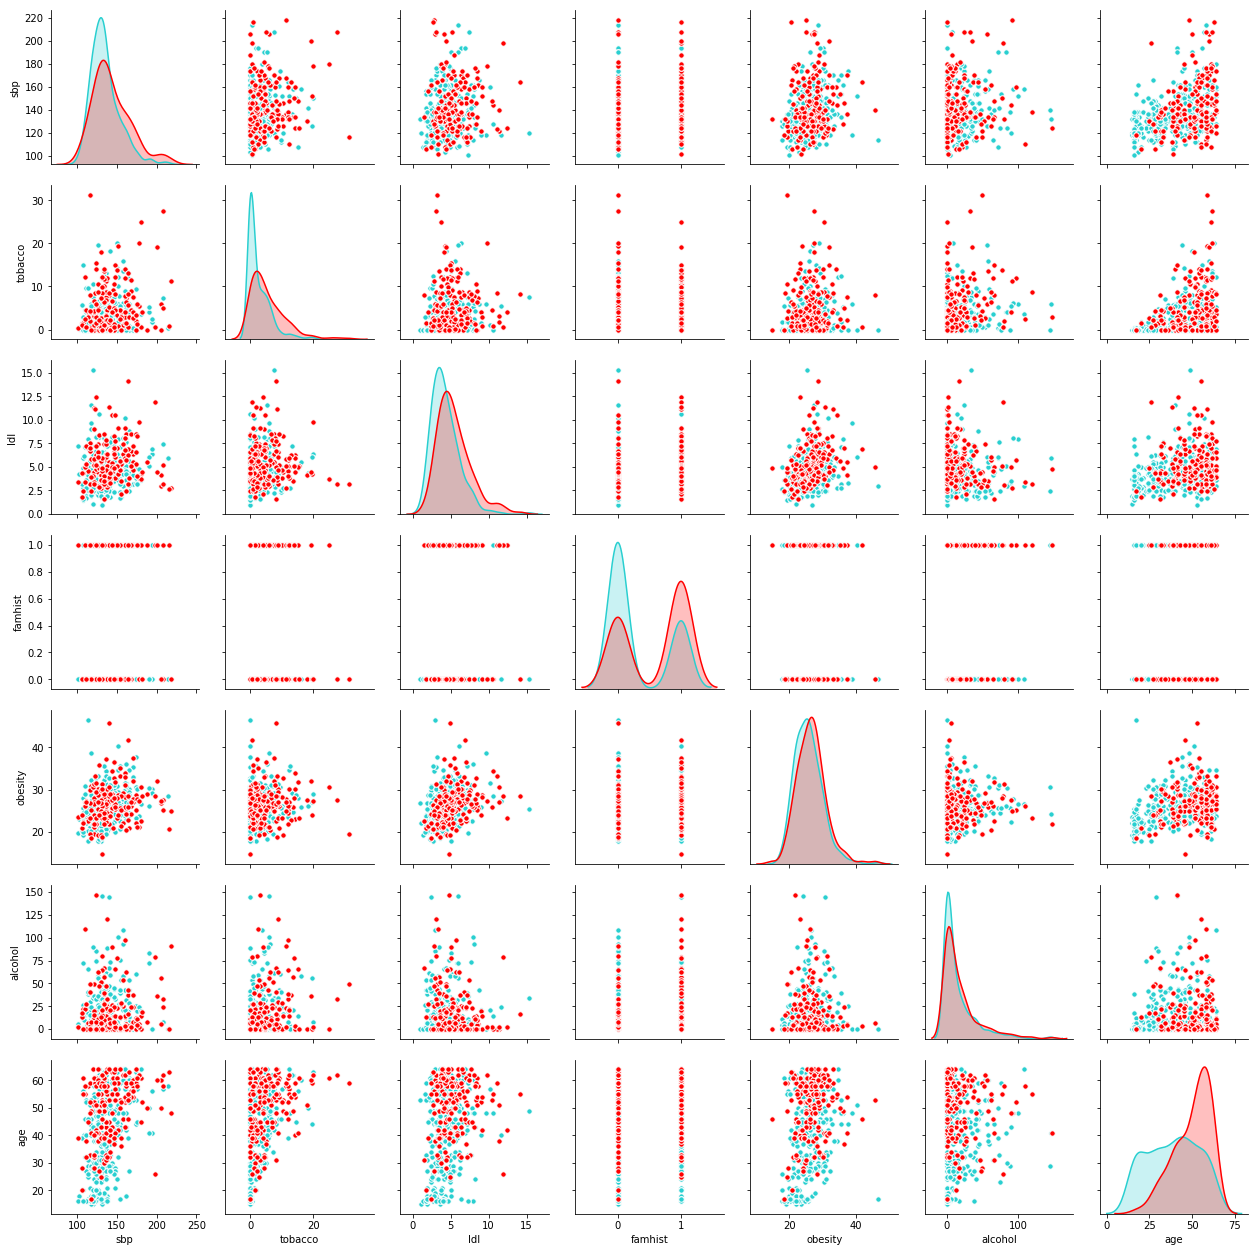

In [3]:
# PAGE 123. FIGURE 4.12. A scatterplot matrix of the South African heart disease data.
#           Each plot shows a pair of risk factors, and the cases and controls are color coded
#           (red is a case). The variable family history of heart disease (famhist) is binary
#           (yes or no).
g = sns.pairplot(df, vars=features, kind="scatter", hue=target[0], 
                 palette=['#29CFD0', '#FF0000'],
                 plot_kws=dict(s=30, linewidth=1))
g._legend.remove()

In [4]:
# convert data to X, y np.arrays
X, y = df[features].values, df[target].values
y_flat = np.squeeze(y)

## Logistic Regression

In [5]:
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

C:\Python64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
# PAGE 122. We fit a logistic-regression model by maximum likelihood, giving the
#           results shown in Table 4.2. This summary includes Z scores for each of the
#           coefficients in the model (coefficients divided by their standard errors); a
#           nonsignificant Z score suggests a coefficient can be dropped from the model.
#           Each of these correspond formally to a test of the null hypothesis that the
#           coefficient in question is zero, while all the others are not (also known as
#           the Wald test). A Z score greater than approximately 2 in absolute value
#           is significant at the 5% level.
lr = sm.Logit(y, sm.add_constant(X)).fit(disp=False)

In [7]:
# PAGE 122. TABLE 4.2. Results from a logistic regression fit to the South African heart
#           disease data.

#           There are some surprises in this table of coefficients, which must be 
#           interpreted with caution. Systolic blood pressure (sbp) is not significant! 
#           Nor is obesity, and its sign is negative. This confusion is a result of the 
#           correlation between the set of predictors. On their own, both sbp and obesity
#           are significant, and with positive sign. However, in the presence of many
#           other correlated variables, they are no longer needed (and can even get a
#           negative sign).
result = zip(['(Intercept)'] + features, lr.params, lr.bse, lr.tvalues)
print('               Coefficient   Std. Error   Z Score')
print('-------------------------------------------------')
for term, coefficient, std_err, z_score in result:
    print(f'{term:>12}   {coefficient:>11.3f}   {std_err:>10.3f}  {z_score:>8.3f}')

               Coefficient   Std. Error   Z Score
-------------------------------------------------
 (Intercept)        -4.130        0.964    -4.283
         sbp         0.006        0.006     1.023
     tobacco         0.080        0.026     3.034
         ldl         0.185        0.057     3.218
     famhist         0.939        0.225     4.177
     obesity        -0.035        0.029    -1.187
     alcohol         0.001        0.004     0.136
         age         0.043        0.010     4.181


## Features Selection
At this stage the analyst might do some model selection; find a subset of the variables that are sufficient for explaining their joint effect on the prevalence of chd. One way to proceed by is to drop the least significant coefficient, and refit the model. This is done repeatedly until no further terms can be dropped from the model.

In [8]:
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

In [9]:
# PAGE 124. A better but more time-consuming strategy is to refit each of the models
#           with one variable removed, and then perform an analysis of deviance to
#           decide which variable to exclude. The residual deviance of a fitted model
#           is minus twice its log-likelihood, and the deviance between two models is
#           the difference of their individual residual deviances (in analogy to sums-of
#           squares).
def deviance(X, y, model):
    return 2*log_loss(y_flat, model.predict_proba(X))

lr = LogisticRegression(solver='lbfgs', max_iter=100000, C=10e10)
features_res = features[:]
X_res = X.copy()
# TODO: learn stopping criteria
for k in range(3):
    i_to_remove, min_dev = None, None
    for i, name in enumerate(features_res):
        X_res_reduced = np.delete(X_res, i, 1)
        dev = deviance(X_res_reduced, y, lr.fit(X_res_reduced, y_flat))
        if i_to_remove is None or min_dev > dev:
            i_to_remove, min_dev = i, dev
    X_res = np.delete(X_res, i_to_remove, 1)
    print(f'REMOVE: {features_res.pop(i_to_remove)}')

REMOVE: alcohol
REMOVE: sbp
REMOVE: obesity


In [10]:
# PAGE 124. TABLE 4.3. Results from stepwise logistic regression ﬁt to South African heart 
#           disease data.
lr = sm.Logit(y, sm.add_constant(X_res)).fit(disp=False)
result = zip(['(Intercept)'] + features_res, lr.params, lr.bse, lr.tvalues)
print('               Coefficient   Std. Error   Z Score')
print('-------------------------------------------------')
for term, coefficient, std_err, z_score in result:
    print(f'{term:>12}   {coefficient:>11.3f}   {std_err:>10.3f}  {z_score:>8.2f}')
    
# PAGE 124. How does one interpret a coefficient of 0.081 (Std. Error = 0.026) for
#           tobacco, for example? Tobacco is measured in total lifetime usage in kilograms, 
#           with a median of 1.0kg for the controls and 4.1kg for the cases. Thus
#           an increase of 1kg in lifetime tobacco usage accounts for an increase in the
#           odds of coronary heart disease of exp(0.081) = 1.084 or 8.4%. Incorporating 
#           the standard error we get an approximate 95% confidence interval of
#           exp(0.081 ± 2 × 0.026) = (1.03, 1.14).

               Coefficient   Std. Error   Z Score
-------------------------------------------------
 (Intercept)        -4.204        0.498     -8.44
     tobacco         0.081        0.026      3.16
         ldl         0.168        0.054      3.09
     famhist         0.924        0.223      4.14
         age         0.044        0.010      4.52


## L1 Regularized Logistic Regression

In [11]:
from sklearn.preprocessing import StandardScaler
from math import log

In [12]:
# PAGE 126.  The variables were all standardized to have unit variance.
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [13]:
# PAGE 126. FIGURE 4.13. L1 regularized logistic regession coefficients for the South
#           African heart disease data, plotted as a function of the L1 norm. The variables
#           were all standardized to have unit variance. The profiles are computed exactly at
#           each of the plotted points.
lr = sm.Logit(y, sm.add_constant(X_scaled))
alpha = np.linspace(0, 82, 100)
b_hat = np.vstack([lr.fit_regularized(disp=False, alpha=a).params[1:] for a in alpha])
b_pow = np.sum(np.abs(b_hat), axis=1)

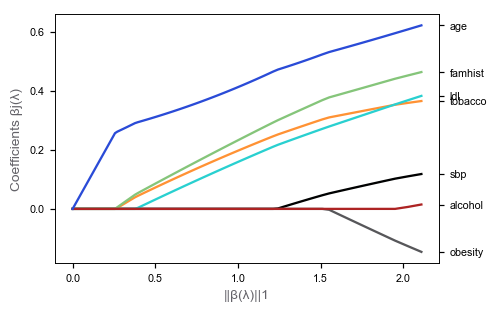

In [14]:
# let's plot the L1 regularization path for the South African heart disease data
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
fig, ax1 = plt.subplots(figsize=(4.5, 3), dpi=110)
colors = ['#000101', '#FF9234', '#29D0D0', '#85C57A', '#57575A', '#AD2323', '#2A4BD7']
GRAY4 = '#646369'
for i in range(7):
    ax1.plot(b_pow, b_hat[:, i], color=colors[i])
ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
plt.setp(ax2, yticks=b_hat[0], yticklabels=features)
for i in ax1.get_yticklabels() + ax1.get_xticklabels() + ax2.get_yticklabels():
    i.set_fontsize(7)
ax1.set_xlabel('||β(λ)||1', color=GRAY4, fontsize=9)
_ = ax1.set_ylabel('Coefficients βj(λ)', color=GRAY4, fontsize=9)

## Natural Cubic Splines Basis Expansion

In [15]:
# sklearn doesn't have natural cubic spline basis expansion
# so, let's implement it with fit-transform method to be used
# in pipeline
class NaturalCubicSplineFeatures():
    def __init__(self, knots):
        self.knots = knots
    
    @staticmethod
    def dk(x, xi_k, xi_K):
        return (max(0, x-xi_k)**3) / (xi_K-xi_k)
    
    @staticmethod
    def do_nc_expansion(x, xis):
        X = np.zeros(shape=(x.shape[0], len(xis)))
        for i in range(X.shape[0]):
            X[i, 0] = 1
            X[i, 1] = x[i]
            for k in range(2, len(xis)):
                X[i, k] = NaturalCubicSplineFeatures.dk(x[i], xis[k-2], xis[-1]) - \
                          NaturalCubicSplineFeatures.dk(x[i], xis[-2], xis[-1])
        return X
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        h = []
        for i in range(X.shape[1]):
            h.append(NaturalCubicSplineFeatures.do_nc_expansion(X[:,i], self.knots[i])[:,1:])            
        result = np.hstack(h)
        return result

In [16]:
# select only significant features
X_selected = X[:,(0, 1, 2, 3, 4, 6)]
# save features' min-max to use in plotting 
X_min, X_max = np.min(X_selected, axis=0), np.max(X_selected, axis=0)
# standartize features
scaler_features = StandardScaler().fit(X_selected)
X_selected_scaled = scaler_features.transform(X_selected)

# PAGE 146. We use four natural spline bases for each term in the model. For example,
#           with X1 representing sbp, h1(X1) is a basis consisting of four basis functions. 
#           This actually implies three rather than two interior knots (chosen at
#           uniform quantiles of sbp), plus two boundary knots at the extremes of the
#           data, since we exclude the constant term from each of the hj.
knots = []
for i in range(X_selected_scaled.shape[1]):
    knots.append(np.unique(np.quantile(X_selected_scaled[:,i], [0, 0.25, 0.5, 0.75, 1])))
# calculate the number of parameters in each component term
degrees_of_freedom = np.array([len(k)-1 for k in knots])

# PAGE 146. Each basis function is evaluated at each of the N samples, 
#           resulting in a N × df basis matrix H.
H = NaturalCubicSplineFeatures(knots).transform(X_selected_scaled)
scaler_basis = StandardScaler().fit(H)
H = scaler_basis.transform(H)

# PAGE 146. At this point the model is like any other linear logistic model, and the algorithms
#           described in Section 4.4.1 apply
lr = LogisticRegression(solver='lbfgs', max_iter=100000, C=10e10).fit(H, y_flat)

In [17]:
# PAGE 146. [See covariance matrix estimation]
predProbs = lr.predict_proba(H)
W = np.diagflat(np.product(predProbs, axis=1))
# add column for intercept into H table
H1 = np.hstack([np.ones((H.shape[0], 1)), H])
cov = np.linalg.inv(H1.T @ W @ H1)
# delete first row and column because it corresponds to intercept
cov = np.delete(cov, 0, axis=0)
cov = np.delete(cov, 0, axis=1)

In [18]:
pts = [0] + list(np.cumsum(degrees_of_freedom))
features_positions = [(pts[i-1], pts[i]-1) for i in range(1, len(pts))]

In [19]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5

# linspace features 
x_axis_values = np.vstack([np.linspace(X_min[i], X_max[i], 100)
                           for i in range(X_min.shape[0])]).T
x_axis_values_ = scaler_features.transform(x_axis_values)
x_axis_values_ = NaturalCubicSplineFeatures(knots).transform(x_axis_values_)
x_axis_values_ = scaler_basis.transform(x_axis_values_)

def plot_term_natural_spline_function(ax1, feature_i, name):
    basis_start, basis_end = features_positions[feature_i]
    feature_basis = x_axis_values_[:,basis_start:basis_end+1]
    feature_cov = cov[basis_start:basis_end+1, basis_start:basis_end+1]
    err = [2*np.sqrt(feature_basis[t:t+1,:] @ feature_cov @ feature_basis[t:t+1,:].T)[0, 0]
           for t in range(100)]
    err = np.array(err)
    x_values = x_axis_values[:,feature_i]
    y_values = np.squeeze(feature_basis @ lr.coef_[:,basis_start:basis_end+1].T)
    y_values_low = y_values - err
    y_values_high = y_values + err
    
    ax1.fill_between(x_values, y_values_low, y_values_high, color='#FFEC8B')
    ax1.plot(x_values, y_values, color='#00FF00', linewidth=0.8)
    
    y_from, y_to = ax1.get_ylim()
    for i in range(X_selected.shape[0]):
        x = X_selected[i, feature_i]
        ax1.plot([x, x], [y_from, y_from+(y_to-y_from)*0.02], 
                 color='red', linewidth=0.5)
    ax1.set_ylim(y_from, y_to)
    
    for l in ax1.get_yticklabels() + ax1.get_xticklabels():
        l.set_fontsize(6)
    ax1.set_xlabel(f'{name}', color=GRAY4, fontsize=8)
    ax1.set_ylabel(f'f({name})', color=GRAY4, fontsize=8)

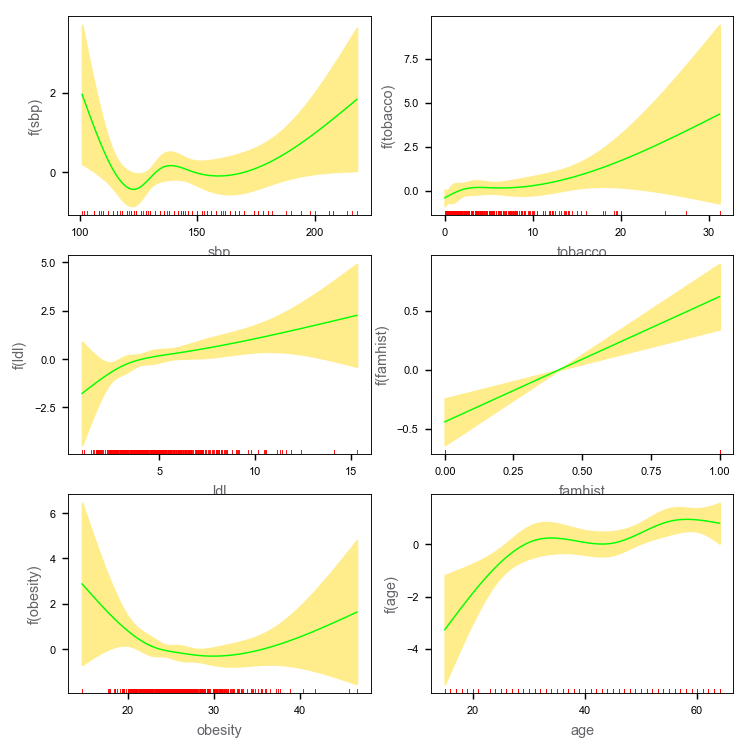

In [20]:
# PAGE 147. FIGURE 5.4. Fitted natural-spline functions for each of the terms in the final
#           model selected by the stepwise procedure. Included are pointwise standard-error
#           bands. The rug plot at the base of each figure indicates the location of each of the
#           sample values for that variable (jittered to break ties).
fig, axarr = plt.subplots(3,2, figsize=(3.3*2, 2.3*3), dpi=130)
plot_term_natural_spline_function(axarr[0, 0], 0, 'sbp')
plot_term_natural_spline_function(axarr[0, 1], 1, 'tobacco')
plot_term_natural_spline_function(axarr[1, 0], 2, 'ldl')
plot_term_natural_spline_function(axarr[1, 1], 3, 'famhist')
plot_term_natural_spline_function(axarr[2, 0], 4, 'obesity')
plot_term_natural_spline_function(axarr[2, 1], 5, 'age')

In [21]:
deviance(H, y, lr)*H.shape[0]

459.5385118659644

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import numpy as np
from patsy import dmatrix
from matplotlib import cm
from collections import OrderedDict
%matplotlib inline
np.set_printoptions(precision=4, suppress=True)

In [2]:
df = pd.read_csv("../data/South African Heart Disease.txt")
names = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']
df['famhist'] = pd.get_dummies(df['famhist'])['Present']
df.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


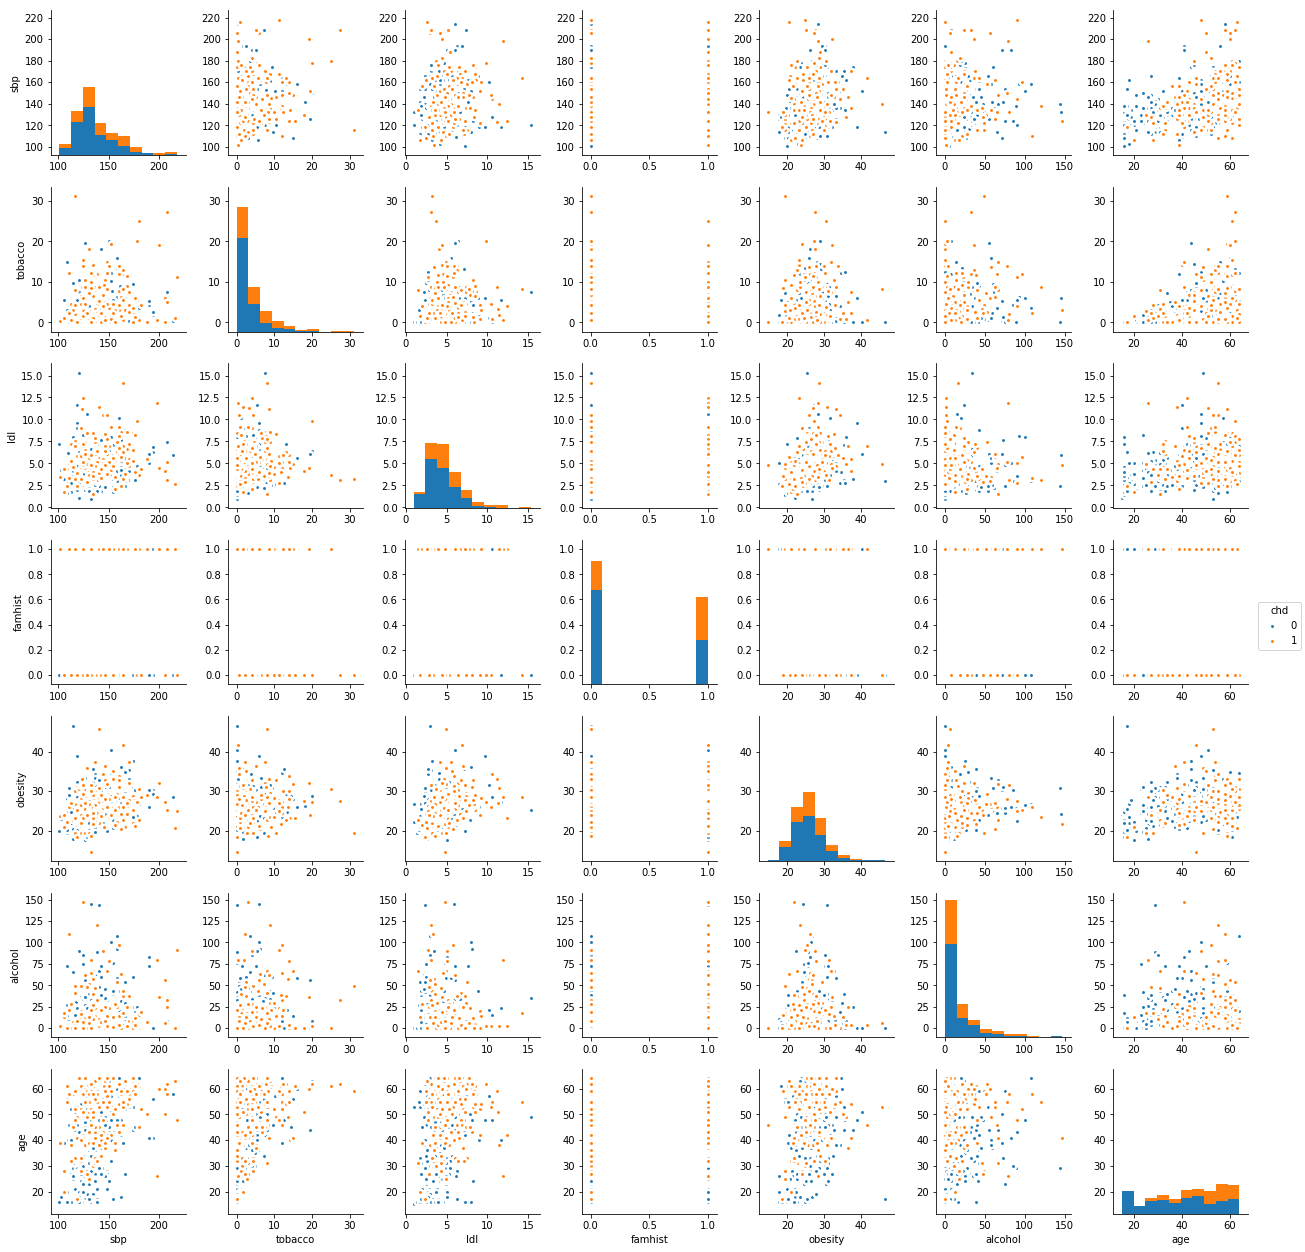

In [3]:
sns.pairplot(df, vars=names, kind="scatter", hue="chd", plot_kws=dict(s=30, edgecolor="white", linewidth=2.5))

In [4]:
X, y = df[names].values, df[['chd']].values

In [5]:
ls = sm.Logit(y, sm.add_constant(X)).fit(disp=False)
print(ls.summary(xname=['(Intercept)'] + names))

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  462
Model:                          Logit   Df Residuals:                      454
Method:                           MLE   Df Model:                            7
Date:                Wed, 06 Feb 2019   Pseudo R-squ.:                  0.1895
Time:                        09:16:24   Log-Likelihood:                -241.59
converged:                       True   LL-Null:                       -298.05
                                        LLR p-value:                 2.259e-21
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
(Intercept)    -4.1296      0.964     -4.283      0.000      -6.019      -2.240
sbp             0.0058      0.006      1.023      0.306      -0.005       0.017
tobacco         0.0795      0.026      3.034    

<h4>Forward-Stepwise Selection</h4>

In [6]:
data = df[names]
remaining, selected, best_model = set(data.columns), [], None
while remaining:
    scores = []
    for candidate in remaining:
        X = data[selected + [candidate]].values
        model = sm.Logit(y, sm.add_constant(X)).fit(disp=False)
        scores.append((model.pvalues[-1], candidate, model))
    scores.sort()
    best_score = scores[0]
    if best_score[0] > 0.05:
        break
    best_model = best_score[2]
    remaining.remove(best_score[1])
    selected.append(best_score[1])

In [7]:
print(best_model.summary(xname=['(Intercept)'] + selected))

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  462
Model:                          Logit   Df Residuals:                      457
Method:                           MLE   Df Model:                            4
Date:                Wed, 06 Feb 2019   Pseudo R-squ.:                  0.1856
Time:                        09:16:24   Log-Likelihood:                -242.72
converged:                       True   LL-Null:                       -298.05
                                        LLR p-value:                 5.251e-23
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
(Intercept)    -4.2043      0.498     -8.436      0.000      -5.181      -3.228
age             0.0440      0.010      4.520      0.000       0.025       0.063
famhist         0.9241      0.223      4.141    

<h4>L1 Regularized Logistic Regression</h4>

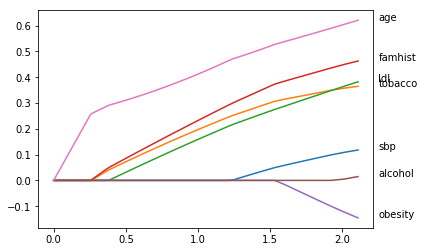

In [8]:
X, y = df[names].values, df[['chd']].values
X = StandardScaler().fit(X).transform(X)
result = []
for alpha in range(1000):
    ls = sm.Logit(y, sm.add_constant(X)).fit_regularized(disp=False, alpha=alpha)
    b_hat = ls.params[1:]
    result.append((np.sum(np.abs(b_hat)), b_hat))
    if b_hat @ b_hat == 0:
        break
result = sorted(result)
plot_x = [e[0] for e in result]
plot_y = np.vstack([e[1] for e in result])
for i in range(7):
    plt.plot(plot_x, plot_y[:,i])
    plt.text(2.25, plot_y[-1,i], names[i])

<h4>Natural-Spline Basis Expansion</h4>

In [9]:
y = df[['chd']].values
# TODO: use patsy instead
def dk(x, xi_k, xi_K):
    return (max(0, x-xi_k)**3 - max(0, x-xi_K)**3) / (xi_K-xi_k)

def do_nc_expansion(x, xi1, xi2, xi3, xi4, xi5):
    X = np.zeros(shape=(x.shape[0], 4))
    for i in range(X.shape[0]):
        X[i, 0] = x[i]
        X[i, 1] = dk(x[i], xi1, xi5) - dk(x[i], xi4, xi5)
        X[i, 2] = dk(x[i], xi2, xi5) - dk(x[i], xi4, xi5)
        X[i, 3] = dk(x[i], xi3, xi5) - dk(x[i], xi4, xi5)
    return X

def get_X_expanded(names):
    X = df[names].values
    X_ = np.ones(shape=(X.shape[0], 1))
    for i, name in enumerate(names):
        if name == 'famhist':
            e = X[:, i].reshape((X.shape[0], 1))
        else:
            knots = np.quantile(X[:,i], (0, 0.25, 0.5, 0.75, 1))
            e = do_nc_expansion(X[:,i], *knots)
        X_ = np.hstack((X_, e))
    return X_

In [10]:
names_left = names[:]
X = get_X_expanded(names_left)
current_ls = sm.Logit(y, X).fit(disp=False)
current_aic = current_ls.aic
while True:
    print('current AIC', current_aic)
    bcwd = []
    for name in names_left:
        test_names = names_left[:]
        test_names.remove(name)
        bcwd.append((sm.Logit(y, get_X_expanded(test_names)).fit(disp=False).aic, name))
    best_aic, best_exclude_name = sorted(bcwd)[0]
    if best_aic < current_aic:
        current_aic = best_aic
        names_left.remove(best_exclude_name)
    else:
        break

current AIC 509.63178580353764
current AIC 502.0879440997786


In [11]:
bcwd

[(503.1641493465693, 'sbp'),
 (506.4752593818633, 'tobacco'),
 (508.3944580417449, 'ldl'),
 (521.4440963087994, 'famhist'),
 (502.2350412213343, 'obesity'),
 (517.8561396226274, 'age')]

In [12]:
name_df = {'sbp': 4, 'tobacco': 4, 'ldl': 4, 'famhist': 1, 'obesity': 4, 'alcohol': 4, 'age': 4}
dfs = [1] + [name_df[n] for n in names_left]
list(zip(['intercept'] + names_left, dfs))

[('intercept', 1),
 ('sbp', 4),
 ('tobacco', 4),
 ('ldl', 4),
 ('famhist', 1),
 ('obesity', 4),
 ('age', 4)]

In [13]:
X = get_X_expanded(names_left)
ls = sm.Logit(y, X).fit(disp=False)
cut_idx = np.cumsum(dfs)[:-1]
th = np.split(ls.params, cut_idx)
h = np.split(X, cut_idx, axis=1)

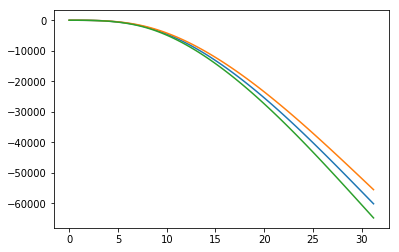

In [14]:
p = 2
X_p = h[p][:, 0]
X_p = np.linspace(min(X_p), max(X_p), 100)
knots = np.quantile(X_p, (0, 0.25, 0.5, 0.75, 1))
X_p_ = do_nc_expansion(X_p, *knots)
cv_p = [np.split(np.split(ls.cov_params(), cut_idx, axis=1)[i], cut_idx, axis=0)[i] for i in range(len(cut_idx)+1)][p]
plt.plot(X_p, X_p_ @ th[p])
_2sigma = 2 * np.sqrt(np.diagonal((X_p_ @ cv_p @ X_p_.T))/462)
plt.plot(X_p, X_p_ @ th[p] + _2sigma)
plt.plot(X_p, X_p_ @ th[p] - _2sigma)

In [123]:
from scipy.interpolate import SmoothBivariateSpline
from scipy.interpolate import Rbf
from scipy.spatial import ConvexHull

def point_in_hull(point, hull, tolerance=1e-12):
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
        for eq in hull.equations)

In [133]:
df1 = df[df.chd == 1]

In [242]:
x, y, z = df.age.values, df.obesity, df.sbp
hull = ConvexHull(np.hstack((df1.age.values.reshape(df1.age.values.shape[0], 1), df1.obesity.values.reshape(df1.obesity.values.shape[0], 1))))

In [243]:
sbs = SmoothBivariateSpline(x, y, z, s=10000000)
rbf = Rbf(x, y, z, smooth=80)

In [244]:
xi, yi = np.meshgrid(np.linspace(15, 65, 100), np.linspace(10, 47, 100))
zi = rbf(xi, yi)
for i in range(xi.shape[0]):
    for j in range(xi.shape[1]):
        if not point_in_hull([xi[i, j], yi[i, j]], hull):
            zi[i, j] = None

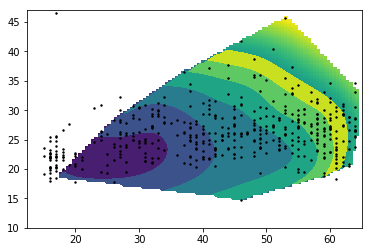

In [248]:
c = plt.pcolormesh(xi, yi, zi)
plt.contourf(xi, yi, zi, levels=[125, 130, 135, 140, 145, 150, 155])
plt.scatter(df.age.values, df.obesity.values, s=2, c='black')

In [204]:
zi[50, 50]

179.5914090761803